In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
archive_path = '/content/drive/MyDrive/archive.zip'

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from zipfile import ZipFile
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
with ZipFile(archive_path, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('traffic-signal-data')

In [ ]:
train_path = '/content/traffic-signal-data/Train'
test_path = '/content/traffic-signal-data/Test'

In [ ]:
# defining a function that will generate label and data from folder's name
from matplotlib.image import imread

def generate_dataset_from_folder(filepath,mode) :
  dataset = []
  if mode == 'train' :
    for folder in os.listdir(filepath):
      folder_path = os.path.join(filepath,folder)
      for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path,image_name)
        image = imread(image_path)
        dataset.append([image,folder])
  
  if mode == 'test' :
    for image_name in os.listdir(filepath):
        # print(image_name)
        if image_name[-3:] != 'png' and image_name[-3:] != 'jpg' :
          continue
        image_path = os.path.join(filepath,image_name)
        image = imread(image_path)
        dataset.append([image])

  return dataset

In [ ]:
len(os.listdir(train_path)[0]) < 3
# os.listdir(train_path)

In [ ]:
dataset = generate_dataset_from_folder(train_path,'train')

In [ ]:
test_dataset = generate_dataset_from_folder(test_path,'test')

In [ ]:
len(test_dataset)

In [ ]:

# def rgb2gray(image_data):
#   x,y = image_data.shape[0],image_data.shape[1]
#   new_image_data = np.empty((x,y))
#   for i in range(x):
#     for j in range(y):
#       R = image_data[i][j][0]
#       G = image_data[i][j][1]
#       B = image_data[i][j][2]
#       new_image_data[i][j] = 0.2125*R + 0.7154*G + 0.0721*B # these values chosen from skimage documentation

#   return new_image_data

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize
image_shape = (32,32,1)
number_label = 43

def reshape_and_grayscale(dataset):
  i = 0
  for data in dataset :
    image_data = data[0]
    
    if len(image_data.shape) > 2 :
      image_data = rgb2gray(image_data) #my version very slow therefore using skimage rgb2gray version
      
    image_data = resize(image_data,image_shape)
    dataset[i][0] = image_data/255 # normalizing : dividing by 255
    i+=1


In [ ]:
def random_test_train_split(dataset,split_ratio):
  length = len(dataset)
  random_permutation = np.random.permutation(length)

  train_set = []
  test_set = []
  for i in range(length):
    if i <= length*split_ratio :
      train_set.append(dataset[random_permutation[i]])
    else :
      test_set.append(dataset[random_permutation[i]])

  return (np.array(train_set), np.array(test_set) )

In [ ]:
reshape_and_grayscale(dataset)

In [ ]:
(train,valid) = random_test_train_split(dataset,split_ratio = 0.8)
print(len(dataset),len(train),len(valid))

In [ ]:
def seperate_x_y(dataset) :
  x_shape = (len(dataset), image_shape[0], image_shape[1], image_shape[2])
  y_shape = (len(dataset), number_label)
  x = np.empty(x_shape)
  y = np.empty(y_shape)
  i = 0
  for data in dataset :
    x[i] = data[0]
    # print(data[1],end=' ')
    y[i] = tf.one_hot(int(data[1]),depth = number_label)
    # y[i] = int(data[1])
    i+=1

  return (x,y)


In [ ]:
train_x,train_y = seperate_x_y(train)
valid_x,valid_y = seperate_x_y(valid)

In [ ]:
# combining reshaping,grayscaling into one pipeline
def transformation_pipeline(data) :
  reshape_and_grayscale(data)
  x,y = seperate_x_y(data)
  return x,y

In [ ]:
# creating my model
input = tf.keras.layers.Input(shape = image_shape)
layer = tf.keras.layers.Conv2D(filters = 32,kernel_size = 3)(input)
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(layer)
layer = tf.keras.layers.Conv2D(filters = 64,kernel_size = 3)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(layer)
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(units = 1024,activation='ReLU')(layer)
output = tf.keras.layers.Dense(units = 43,activation='softmax')(layer)

In [ ]:
model = tf.keras.models.Model(inputs = [input],outputs = [output])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0     

In [ ]:
# debugging lines
# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_x,train_y,
  validation_data=(valid_x,valid_y),
  epochs=3
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


981/981 [==============================] - 16s 5ms/step - loss: 2.4589 - accuracy: 0.3242 - val_loss: 0.7996 - val_accuracy: 0.7753
Epoch 2/3
981/981 [==============================] - 4s 4ms/step - loss: 0.4446 - accuracy: 0.8767 - val_loss: 0.2818 - val_accuracy: 0.9295
Epoch 3/3
981/981 [==============================] - 4s 5ms/step - loss: 0.2012 - accuracy: 0.9467 - val_loss: 0.1858 - val_accuracy: 0.9545


In [ ]:
# history.history.keys()

### **Testing the model on unseen data**

In [ ]:
test_dataset

[[array([[[0.12156863, 0.09411765, 0.08235294],
          [0.12156863, 0.09803922, 0.08235294],
          [0.11764706, 0.09411765, 0.08235294],
          ...,
          [0.12156863, 0.10588235, 0.08627451],
          [0.14901961, 0.12941177, 0.12156863],
          [0.14901961, 0.13725491, 0.13725491]],
  
         [[0.11764706, 0.09803922, 0.08627451],
          [0.11372549, 0.09411765, 0.07843138],
          [0.11372549, 0.09411765, 0.08235294],
          ...,
          [0.1254902 , 0.10980392, 0.09019608],
          [0.14509805, 0.13333334, 0.1254902 ],
          [0.14509805, 0.13725491, 0.13725491]],
  
         [[0.11372549, 0.10196079, 0.09019608],
          [0.10588235, 0.09019608, 0.07843138],
          [0.10980392, 0.09019608, 0.08235294],
          ...,
          [0.12941177, 0.11764706, 0.09019608],
          [0.17254902, 0.16862746, 0.15686275],
          [0.14901961, 0.14117648, 0.14509805]],
  
         ...,
  
         [[0.10196079, 0.08627451, 0.07450981],
          [0.0

### **Predicting the model on user input image**

In [ ]:
class_labels = [
'End of no passing by vehicles over 3.5 metric tons',
'End of no passing',
'Roundabout mandatory',
'Keep left',
'Keep right',
'Go straight or left',
'Go straight or right',
'Ahead only',
'Turn left ahead',
'Turn right ahead',
'End of all speed and passing limits',
'Wild animals crossing',
'Beware of ice/snow',
'Bicycles crossing',
'Children crossing',
'Pedestrians',
'Traffic signals',
'Road work',
'Road narrows on the right',
'Slippery road',
'Bumpy road',
'Double curve',
'Dangerous curve to the right',
'Dangerous curve to the left',
'General caution',
'No entry',
'Vehicles over 3.5 metric tons prohibited',
'No vehicles',
'Stop',
'Yield',
'Priority road',
'Right-of-way at the next intersection',
'No passing for vehicles over 3.5 metric tons',
'No passing',
'Speed limit (120km/h)',
'Speed limit (100km/h)',
'End of Speed limit (80km/h)',
'Speed limit (80km/h)',
'Speed limit (70km/h)',
'Speed limit (60km/h)',
'Speed limit (5Okm/h)',
'Speed limit (30km/h)',
'Speed limit (20km/h)'
]

In [ ]:
import matplotlib.image as img

Speed limit (70km/h)


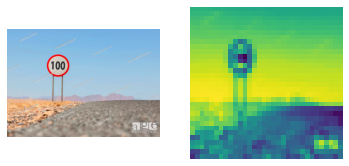

In [ ]:
# custom test image 
test_image_path = '100.jpg'
test_image = img.imread(test_image_path)
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(test_image)
plt.subplot(1,2,2)
plt.axis('off')
image = rgb2gray(test_image)
image = resize(image,(32,32,1))
image = image/255
image_to_display = np.squeeze(image)
plt.imshow(image_to_display)
test_image_batch = np.expand_dims(image,axis=0)
index = np.argmax(model.predict(test_image_batch),axis = 1)[0]
print(class_labels[42 - index])

In [ ]:
model.save_weights('my_checkpoint')